In [ ]:
!pip install -q accelerate peft bitsandbytes transformers trl requests

In [1]:
import os
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
)
from peft import LoraConfig, PeftModel
from trl import SFTTrainer

2024-06-27 18:22:17.876103: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-27 18:22:17.876208: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-27 18:22:17.999928: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import pandas as pd
import numpy as np
df=pd.read_csv("/kaggle/input/suicide-watch/Suicide_Detection.csv")
df=df.sample(frac=0.2,random_state=42)
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
def process(text):
    text=re.sub(text_cleaning_re,' ',str(text).lower()).strip()
    tokens=[]
    for i in text.split():
        if i not in stop_words:
            tokens.append(stemmer.stem(i))
    return ' '.join(tokens)
df['text']=df['text'].map(lambda x:process(x))
df

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Unnamed: 0,text,class
74414,111734,know 7 month self harm free urg get stronger s...,suicide
149516,224358,start becom rich start compani becom 16 afford...,non-suicide
12484,18790,poem haiku u game dev hi hello hello stop fuck...,non-suicide
14043,21196,honest got idea anymor feel everyon fake feel ...,suicide
30673,46089,ever cri like think unfair life cri cri ever s...,non-suicide
...,...,...,...
7259,10898,wish reason die like cancer ill instead health...,suicide
4207,6295,want friend final leavei want abl die without ...,suicide
92900,139533,guess got headpat cute girl yup one time ladi,non-suicide
17403,26203,program usual god good almost profession encou...,non-suicide


In [3]:
df.rename(columns={'text': 'clean_text','class': 'is_depression'}, inplace=True)
df['is_depression'] = df['is_depression'].replace({'suicide': 1, 'non-suicide': 0})
df=df.drop(columns=["Unnamed: 0"],axis=0)
df.head()

/tmp/ipykernel_108/3661756070.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['is_depression'] = df['is_depression'].replace({'suicide': 1, 'non-suicide': 0})


,clean_text,is_depression
74414,know 7 month self harm free urg get stronger s...,1
149516,start becom rich start compani becom 16 afford...,0
12484,poem haiku u game dev hi hello hello stop fuck...,0
14043,honest got idea anymor feel everyon fake feel ...,1
30673,ever cri like think unfair life cri cri ever s...,0


In [4]:
df.is_depression.value_counts()

is_depression
0    23287
1    23128
Name: count, dtype: int64

In [5]:
from sklearn.model_selection import train_test_split
X_train = list()
X_test = list()
for label in [0,1]:
    train, test  = train_test_split(df[df.is_depression==label],
                                    train_size=1000,
                                    test_size=100,
                                    random_state=42)
    X_train.append(train)
    X_test.append(test)

X_train = pd.concat(X_train).sample(frac=1, random_state=10)
X_test = pd.concat(X_test).sample(frac=1, random_state=10)
X_train

,clean_text,is_depression
113957,fun fact figment imagin reason read allow,0
116724,gf ruin entir life sent nude muslim mother fee...,1
142722,feel cheat feel fuck cheat like fuck joke 3 ta...,1
118467,lunch recommend song listen lunch,0
212427,anyon around let fuck die alreadyi fight every...,1
...,...,...
24179,sure peopl miss get happier long run ad much a...,1
203837,make sure son safe go partner quit abus stuck ...,1
22021,panick sent pictur bf discord text horni get n...,0
69935,trappedtri jump bridg surviv tri jump bridg go...,1


In [6]:
eval_idx = [idx for idx in df.index if idx not in list(X_train.index) + list(X_test.index)]
X_eval = df[df.index.isin(eval_idx)]
X_eval = (X_eval
          .groupby('is_depression', group_keys=False)
          .apply(lambda x: x.sample(n=200,random_state=10, replace=True)))
X_train = X_train.reset_index(drop=True)

/tmp/ipykernel_108/3295932608.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=200,random_state=10, replace=True)))


In [7]:
def generate_prompt(data_point):
    return f"""analyse the following sentence in square brackets and determine if it has depression or not, return the answer as 0 for no deression and 1 for depression. [{data_point["clean_text"]}]={data_point["is_depression"]}""".strip()
X_train = pd.DataFrame(X_train.apply(generate_prompt, axis=1),
                       columns=["clean_text"])
X_eval = pd.DataFrame(X_eval.apply(generate_prompt, axis=1),
                      columns=["clean_text"])
y_true = X_test.is_depression


In [8]:
def generate_test_prompt(data_point):
    return f"""analyse the following sentence in square brackets and determine if it has depression or not, return the answer as 0 for no deression and 1 for depression. [{data_point["clean_text"]}] =""".strip()
X_test = pd.DataFrame(X_test.apply(generate_test_prompt, axis=1), columns=["clean_text"])

In [9]:
X_train.iloc[0].clean_text

'analyse the following sentence in square brackets and determine if it has depression or not, return the answer as 0 for no deression and 1 for depression. [fun fact figment imagin reason read allow]=0'

In [10]:
from datasets import Dataset
train_data = Dataset.from_pandas(X_train)
eval_data = Dataset.from_pandas(X_eval)

In [11]:
train_data


Dataset({
    features: ['clean_text'],
    num_rows: 2000
})

In [15]:
model_name = "klyang/MentaLLaMA-chat-7B-hf"
new_model = "mentalLlama-finetune-suicide"

################################################################################
# QLoRA parameters
################################################################################

# LoRA attention dimension
lora_r = 64

# Alpha parameter for LoRA scaling
lora_alpha = 16

# Dropout probability for LoRA layers
lora_dropout = 0.1

################################################################################
# bitsandbytes parameters
################################################################################

# Activate 4-bit precision base model loading
use_4bit = True

# Compute dtype for 4-bit base models
bnb_4bit_compute_dtype = "float16"

# Quantization type (fp4 or nf4)
bnb_4bit_quant_type = "nf4"

# Activate nested quantization for 4-bit base models (double quantization)
use_nested_quant = False

################################################################################
# TrainingArguments parameters
################################################################################

# Output directory where the model predictions and checkpoints will be stored
output_dir = "results"

# Number of training epochs
num_train_epochs = 1

# Enable fp16/bf16 training (set bf16 to True with an A100)
fp16 = False
bf16 = False

# Batch size per GPU for training
per_device_train_batch_size = 2

# Batch size per GPU for evaluation
per_device_eval_batch_size = 2

# Number of update steps to accumulate the gradients for
gradient_accumulation_steps = 1

# Enable gradient checkpointing
gradient_checkpointing = True

# Maximum gradient normal (gradient clipping)
max_grad_norm = 0.3

# Initial learning rate (AdamW optimizer)
learning_rate = 2e-4

# Weight decay to apply to all layers except bias/LayerNorm weights
weight_decay = 0.001

# Optimizer to use
optim = "paged_adamw_32bit"

# Learning rate schedule
lr_scheduler_type = "cosine"

# Number of training steps (overrides num_train_epochs)
max_steps = -1

# Ratio of steps for a linear warmup (from 0 to learning rate)
warmup_ratio = 0.03

# Group sequences into batches with same length
# Saves memory and speeds up training considerably
group_by_length = True

# Save checkpoint every X updates steps
save_steps = 0

# Log every X updates steps
logging_steps = 25

################################################################################
# SFT parameters
################################################################################

# Maximum sequence length to use
max_seq_length = None

# Pack multiple short examples in the same input sequence to increase efficiency
packing = False

# Load the entire model on the GPU 0
device_map = {"": 0}

In [16]:
# Load tokenizer and model with QLoRA configuration
compute_dtype = getattr(torch, "float16")

quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=False,
)

# Check GPU compatibility with bfloat16
if compute_dtype == torch.float16 and use_4bit:
    major, _ = torch.cuda.get_device_capability()
    if major >= 8:
        print("=" * 80)
        print("Your GPU supports bfloat16: accelerate training with bf16=True")
        print("=" * 80)

# Load base model
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=quant_config,
    device_map=device_map
)
model.config.use_cache = False
model.config.pretraining_tp = 1

# Load LLaMA tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right" # Fix weird overflow issue with fp16 training

# Load LoRA configuration
peft_params = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.1,
    r=64,
    bias="none",
    task_type="CAUSAL_LM",
)

# Set training parameters
training_params = TrainingArguments(
    output_dir="./results",
    num_train_epochs=1,
    per_device_train_batch_size=2,
    gradient_accumulation_steps=1,
    optim="paged_adamw_32bit",
    save_steps=75,
    logging_steps=100,
    learning_rate=2e-4,
    weight_decay=0.001,
    fp16=True,
    bf16=False,
    max_grad_norm=0.3,
    max_steps=-1,
    warmup_ratio=0.03,
    group_by_length=True,
    lr_scheduler_type="cosine",
    report_to="tensorboard",
    evaluation_strategy="steps"
)

# Set supervised fine-tuning parameters
trainer = SFTTrainer(
    model=model,
    train_dataset=train_data,
    eval_dataset=eval_data,
    peft_config=peft_params,
    dataset_text_field="clean_text",
    max_seq_length=1024,
    tokenizer=tokenizer,
    args=training_params,
    packing=False,
)

# Train model
trainer.train()

config.json:   0%|          | 0.00/691 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00006.safetensors:   0%|          | 0.00/4.84G [00:00<?, ?B/s]

model-00002-of-00006.safetensors:   0%|          | 0.00/4.86G [00:00<?, ?B/s]

model-00003-of-00006.safetensors:   0%|          | 0.00/4.86G [00:00<?, ?B/s]

model-00004-of-00006.safetensors:   0%|          | 0.00/4.86G [00:00<?, ?B/s]

model-00005-of-00006.safetensors:   0%|          | 0.00/4.86G [00:00<?, ?B/s]

model-00006-of-00006.safetensors:   0%|          | 0.00/2.68G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

Some weights of LlamaForCausalLM were not initialized from the model checkpoint at klyang/MentaLLaMA-chat-7B-hf and are newly initialized: ['model.layers.3.self_attn.rotary_emb.inv_freq', 'model.layers.25.self_attn.rotary_emb.inv_freq', 'model.layers.20.self_attn.rotary_emb.inv_freq', 'model.layers.2.self_attn.rotary_emb.inv_freq', 'model.layers.6.self_attn.rotary_emb.inv_freq', 'model.layers.22.self_attn.rotary_emb.inv_freq', 'model.layers.7.self_attn.rotary_emb.inv_freq', 'model.layers.28.self_attn.rotary_emb.inv_freq', 'model.layers.29.self_attn.rotary_emb.inv_freq', 'model.layers.30.self_attn.rotary_emb.inv_freq', 'model.layers.17.self_attn.rotary_emb.inv_freq', 'model.layers.11.self_attn.rotary_emb.inv_freq', 'model.layers.19.self_attn.rotary_emb.inv_freq', 'model.layers.14.self_attn.rotary_emb.inv_freq', 'model.layers.13.self_attn.rotary_emb.inv_freq', 'model.layers.10.self_attn.rotary_emb.inv_freq', 'model.layers.15.self_attn.rotary_emb.inv_freq', 'model.layers.23.self_attn.rota

generation_config.json:   0%|          | 0.00/183 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/935 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/peft/utils/other.py:102: FutureWarning: prepare_model_for_int8_training is deprecated and will be removed in a future version. Use prepare_model_for_kbit_training instead.
  warnings.warn(


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss
100,3.180200,3.411517
200,2.604400,3.118543
300,2.531100,3.008431
400,2.514900,2.900710
500,2.470800,2.893750


/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain curr

TrainOutput(global_step=500, training_loss=2.660294250488281, metrics={'train_runtime': 2413.4574, 'train_samples_per_second': 0.829, 'train_steps_per_second': 0.207, 'total_flos': 5150894648524800.0, 'train_loss': 2.660294250488281, 'epoch': 1.0})

In [29]:
trainer.train()

Step,Training Loss,Validation Loss
100,2.359200,3.078260
200,2.395800,3.019224
300,2.393500,2.882952
400,2.233100,2.816021
500,2.315800,2.811444


/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain curr

TrainOutput(global_step=500, training_loss=2.339471435546875, metrics={'train_runtime': 2396.6844, 'train_samples_per_second': 0.834, 'train_steps_per_second': 0.209, 'total_flos': 5338081116487680.0, 'train_loss': 2.339471435546875, 'epoch': 1.0})

In [18]:
l=list(X_test['clean_text'])
l[1]

'analyse the following sentence in square brackets and determine if it has depression or not, return the answer as 0 for no deression and 1 for depression. [get peopl believ flat earth besid evid prove would nasa lie someth like gain] ='

In [19]:
#import tqdm
def predict(test, model, tokenizer):
    y_pred = []
    for i in range(X_test.shape[0]):
        prompt = X_test.iloc[i]["clean_text"]
        pipe = pipeline(task="text-generation",
                        model=model,
                        tokenizer=tokenizer,
                        max_new_tokens = 32
                       )
        result = pipe(prompt)
        answer = result[0]['generated_text'].split("=")[-1]
        if "1" in answer:
            y_pred.append(1)
        else:
            y_pred.append(0)
    return y_pred

In [23]:
prompt = X_test.iloc[3]["clean_text"]
pipe = pipeline(task="text-generation",
                model=model,
                tokenizer=tokenizer,
                max_new_tokens = 32
                )
result = pipe(prompt)
print(result)
answer = result[0]['generated_text'].split("=")[-1]
answer,y_true[3]

[{'generated_text': 'analyse the following sentence in square brackets and determine if it has depression or not, return the answer as 0 for no deression and 1 for depression. [im total complet done two year enough tortur long stori one eat two year simpli take anymor er prepar wall text stori reddit two year ago cousin grown togeth close could move away haida gwaii queen charlott island still kept touch text phone call alway lot problem home father fair abus mother sat back watch alway troubl school bulli etc suffer depress sinc mayb age 10 close alway came help alway happi oblig year move charlott thing began move downhil alarm rate alway got phone call father finish beat yell twelv year old boy like forc move across sea tri start anew new communiti much anyway one night get realli desper phone call 8pm exhaust sleep friend hous figur anoth one rant guess mean tire realli tri help offer advic usual would bare manag mutter repli necessari 3am came guess could tell fall asleep despit b

(' 1.00000000000000000000000000000', 1)

In [21]:
y_true=y_true.tolist()

In [22]:
y_true[1]

0

In [30]:
y_pred=predict(test=X_test,model=model,tokenizer=tokenizer)

In [31]:
len(y_pred),len(y_true)

(200, 200)

In [33]:
def calculate_accuracy(y_true, y_pred):
    """
    Calculate accuracy given true labels and predicted labels.

    Args:
    - y_true (list): List of true labels
    - y_pred (list): List of predicted labels

    Returns:
    - accuracy (float): Accuracy score
    """
    # Check if the lengths of y_true and y_pred are the same
    if len(y_true) != len(y_pred):
        raise ValueError("Lengths of y_true and y_pred must be the same.")

    # Calculate accuracy
    correct_predictions = sum(1 for true, pred in zip(y_true, y_pred) if true == pred)
    total_predictions = len(y_true)
    accuracy = correct_predictions / total_predictions

    return accuracy


#y_true=y_true.tolist()
accuracy = calculate_accuracy(y_true, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.895


In [ ]:
import torch
# Assuming you're using PyTorch

# Clear cache
torch.cuda.empty_cache()



# Run garbage collection
import gc
gc.collect()


F1 Score: 0.8949973749343734


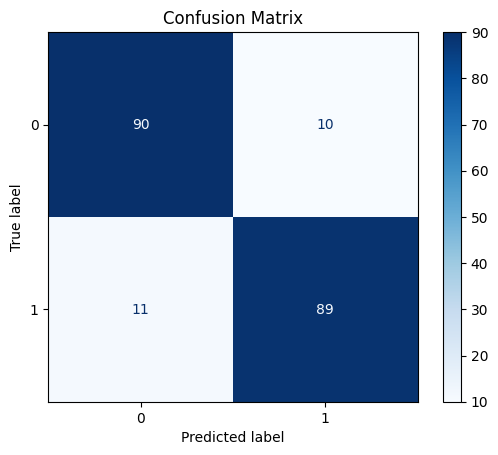

In [32]:
import numpy as np
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


f1 = f1_score(y_true, y_pred, average='weighted')
print(f'F1 Score: {f1}')

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()
